In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def save(_model, _name):
    pickle.dump(_model, open(_name, 'wb'))


def load(_name):
    return pickle.load(open(_name, 'rb'))

In [3]:
df = pd.read_csv('data/AMF_train_X_XCZw8r3.csv')
df = df.replace(np.nan, '0', regex=True)
df['Share'] = df['Share'].str.extract('(\d+)')
df['Day'] = df['Day'].str.extract('(\d+)')
# df['Trader'] = df['Trader'].str.extract('(\d+)')

for i in df:
    if i != 'Trader':
        df[i] = pd.to_numeric(df[i])

df.info()
save(df, 'data.p')

Traders = df['Trader'].unique()


def trader_index(_name):
    return np.where(Traders == _name)[0][0]


# def data_trader(_name):
#     return df[df['Trader'] == _name]

df = df.drop(['Index', 'Trader'], axis=1)
save(df, 'data_1.p')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105782 entries, 0 to 105781
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Index                       105782 non-null  int64  
 1   Share                       105782 non-null  int64  
 2   Day                         105782 non-null  int64  
 3   Trader                      105782 non-null  object 
 4   OTR                         105782 non-null  float64
 5   OCR                         105782 non-null  float64
 6   OMR                         105782 non-null  float64
 7   min_time_two_events         105782 non-null  float64
 8   mean_time_two_events        105782 non-null  float64
 9   10_p_time_two_events        105782 non-null  float64
 10  med_time_two_events         105782 non-null  float64
 11  25_p_time_two_events        105782 non-null  float64
 12  75_p_time_two_events        105782 non-null  float64
 13  90_p_time_two_

In [15]:
data_1 = load('data_1.p')
from sklearn.preprocessing import MinMaxScaler
t = MinMaxScaler()
t.fit(data_1)
X_1 = t.transform(data_1)
save(X_1, 'X_1.p')

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

In [6]:
# Shape of input and latent variable
data_1 = load('data_1.p')

n_input = data_1.shape[1]

# Encoder structure
n_encoder1 = int(data_1.shape[1] * 0.7)
n_encoder2 = int(n_encoder1 * 0.6)

n_latent = 2

# Decoder structure
n_decoder2 = n_encoder2
n_decoder1 = n_encoder1

In [4]:
reg = MLPRegressor(hidden_layer_sizes=(n_encoder1, n_encoder2, n_latent,
                                       n_decoder2, n_decoder1),
                   activation='tanh',
                   solver='adam',
                   learning_rate_init=0.0001,
                   max_iter=1000,
                   tol=0.0001)

reg.fit(X_INPUT, X_INPUT)

# for _ in range(100):
#     reg.fit(X_1, X_1)
# reg.set_params(tol=0.0000001)
# save(reg, 'reg.p')

reg = load('reg.p')

In [17]:
reg

MLPRegressor(activation='tanh', hidden_layer_sizes=(25, 15, 2, 15, 25),
             learning_rate_init=0.0001, max_iter=1000, tol=1e-07, verbose=True,
             warm_start=True)

In [7]:
def encoder(data):
    data = np.asmatrix(data)

    encoder1 = data * reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1)) / (np.exp(encoder1) +
                                                         np.exp(-encoder1))

    encoder2 = encoder1 * reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2)) / (np.exp(encoder2) +
                                                         np.exp(-encoder2))

    latent = encoder2 * reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent)) / (np.exp(latent) +
                                                   np.exp(-latent))

    return np.asarray(latent)

In [11]:
X_1 = load('X_1.p')
X_e = encoder(X_1)

In [9]:
X_0 = load('data.p')

In [8]:
y_0_dict = load('y_0_dict.p')

In [12]:
from numpy.random import default_rng

rng = default_rng()

In [14]:
X_0.shape

(105782, 39)

In [15]:
from matplotlib.lines import Line2D

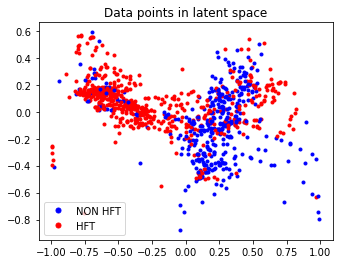

In [19]:
numbers = rng.choice(len(X_0['Trader']), size=2000, replace=False)
fig, ax = plt.subplots()

# for _ in range(len(X_0['Trader'])):
for _ in numbers:
    X_i = X_e[_]
    s = '.'
    tp = y_0_dict[X_0['Trader'][_]]
    if tp == 'HFT':
        s = 'r' + s
#         continue
    elif tp == 'NON HFT':
        s = 'b' + s
#         continue
    else:
        s = 'k' + s
        continue
    ax.plot(X_i[0], X_i[1], s)

blue = Line2D([], [],
              color='blue',
              marker='.',
              linestyle='None',
              markersize=10,
              label='NON HFT')
red = Line2D([], [],
             color='red',
             marker='.',
             linestyle='None',
             markersize=10,
             label='HFT')
black = Line2D([], [],
               color='black',
               marker='.',
               linestyle='None',
               markersize=10,
               label='MIX')
ax.set_aspect(1)
plt.legend(handles=[blue, red])
plt.title('Data points in latent space')
plt.savefig('latent-2.png', dpi=300, format='png')

plt.show()

In [129]:
X_e

array([[ 0.12952289, -0.25001843],
       [-0.62765222,  0.30757911],
       [-0.62612893,  0.2644987 ],
       ...,
       [ 0.08337542, -0.43063765],
       [ 0.13923535, -0.37514994],
       [-0.56915376,  0.05421192]])

In [146]:
def phi(_N, _k=17):
    def phi0(s):
        return np.exp(-_k * s**2)

    _phi = np.array([
        phi0(_N + 1),
        phi0(_N + 1 / 2),
        phi0(_N),
        phi0(_N - 1 / 2),
        phi0(_N - 1)
    ])
    _phi = np.tensordot(_phi[:, 0], _phi[:, 1], 0)
    return np.ravel(_phi)


def u(_P, _a):
    return _a * phi(_P)


def x2y(_X, _a):
    _Traders = _X['Trader'].unique()
    _y = {}
    for _t in _Traders:
        _X_t = _X[_X['Trader'] == _t]
        _l = _X_t.shape[0]
        _s = 0
        for _i in range(_l):
            _P_i = np.array([_X_t['P0'][_i], _X_t['P1'][_i]])
            _s += u(_P_i, _a)

        if _s < 1:
            _y[_t] = 'NON HFT'
        elif _s > np.exp(1):
            _y[_t] = 'HFT'
        else:
            _y[_t] = 'MIX'
    return _y


def loss(_y_pred):
    _Y_PRED = np.array(_y_pred.values())
    _Y_TRUE = np.array([y_0_dict[_k] for _k in _y_pred.keys()])
    return metrics.f1_score(_Y_TRUE, _Y_PRED, average="micro")

In [147]:
from multiprocessing import Pool
from functools import partial

In [161]:
A = np.zeros(25)
J = 0
save((A, J), 'A.p')

In [160]:
_M=32
_rng = default_rng()
_numbers = _rng.choice(len(X_0['Trader']), size=_M, replace=False)
# _X_M = [X_e[_] for _ in _numbers]
# _t_M = [X_0['Trader'][_] for _ in _numbers]

# _df = pd.DataFrame()
# _df['Trader'] = _t_M
# _df['Trader'] = _t_M

X_all.iloc[_numbers].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 82378 to 83901
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Trader  32 non-null     object 
 1   P0      32 non-null     float64
 2   P1      32 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [ ]:
def loss_compare(_A0, _A1, _M=32):
    with Pool() as p:
        _rng = default_rng()
        _numbers = _rng.choice(len(X_0['Trader']), size=_M, replace=False)
        data.iloc[_numbers]
        _X_M = [X_e[_] for _ in _numbers]
        _t_M = [X_0['Trader'][_] for _ in _numbers]

        for _ in numbers:
            X_i = X_e[_]
        _winds = p.map(create_wind, range(_M))
        _J0 = p.map(partial(loss, _A0), _winds)
        _J1 = p.map(partial(loss, _A1), _winds)
        _J0 = np.mean(_J0)
        _J1 = np.mean(_J1)
        if _J0 < _J1:
            return False, _J0
        return True, _J1


def train(_i, _M=10):
    print(f'\nTraining {_i}\n')
    _A, _J = load()
    print(_J)

    for _j in range(A_SIZE):
        np.random.seed()

        _A, _J = load()
        print('.', end='')
        _ita = 0.1
        for _ in range(_M):
            _A_new = _A
            _A_new[_i][_j] *= _ita * np.random.randn() + 1
            _A_new[_i][_j] += _ita * np.random.randn()
            _cond, _J_new = loss_compare(_A, _A_new, _M)
            if _cond:
                _A = _A_new
                _J = _J_new
            elif np.random.randint(2) == 0:
                _ita *= 2
            else:
                _ita *= 1 / 2

        _A_old, _J_old = load()
        if _J_new < _J_old:
            _cond, _J_new = loss_compare(_A_old, _A, 10000)
            if _cond:
                save(_A_new, _J_new)
                print()
                print(_A[_i], _J_new)

    # _A, _J = load()
    # _J_alt = loss_M(_A, 100000)
    # if _J_alt > _J:
    #     save(_A, (_J_alt + _J) / 2)
    #     print()
    #     return train(_i, _M=_M)

    # print()
    return False


def train_all(_M=10):
    for _ in range(T):
        _res = train(T - _ - 1, _M=_M)
        while _res:
            _res = train(T - _ - 1, _M=_M)


# A = np.zeros((T, A_SIZE))
# J = np.inf
#print(load())
#A,_ = load()
#save(A,218)
#print(load())

# save(A, J)
#print(load())
while True:
    train_all(_M=64)

In [125]:
X_0['S'] = 0.0
X_0['P0'] = X_e[:, 0]
X_0['P1'] = X_e[:, 1]
X_2 = X_0[['Trader', 'P0', 'P1', 'S']]
X_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105782 entries, 0 to 105781
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Trader  105782 non-null  object 
 1   P0      105782 non-null  float64
 2   P1      105782 non-null  float64
 3   S       105782 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.2+ MB


In [131]:
y_true = np.array([y_0_dict[_t] for _t in X_0['Trader']])
y_true.shape

(105782,)

In [132]:
X_3 = X_0[['P0', 'P1']]
X_3.shape

(105782, 2)

In [152]:
X_all = X_0[['Trader', 'P0', 'P1']]
X_all.shape
X_all.info()
save(X_all, 'X_all.p')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105782 entries, 0 to 105781
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Trader  105782 non-null  object 
 1   P0      105782 non-null  float64
 2   P1      105782 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.4+ MB


In [133]:
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split

In [134]:
save(X_3, 'X_3.p')
save(y_true, 'y_true.p')

In [150]:
X_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105782 entries, 0 to 105781
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   P0      105782 non-null  float64
 1   P1      105782 non-null  float64
dtypes: float64(2)
memory usage: 1.6 MB


In [136]:
from sklearn import metrics

In [144]:
X = load('X_3.p')
Y = load('y_true.p')
ratio = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio)
sgd_regressor = SGDClassifier().fit(X_train, Y_train)
_pred = sgd_regressor.predict(X_test)
metrics.f1_score(Y_test, _pred, average="micro")

0.5635733417362534

In [162]:
train_test_split(X_all, test_size=ratio)

[           Trader        P0        P1
 99335  Trader_451 -0.455565  0.094534
 62672  Trader_312  0.392256 -0.028008
 33976  Trader_209 -0.476229  0.379379
 83794  Trader_386 -0.752198  0.139296
 66357  Trader_329 -0.736015  0.148712
 ...           ...       ...       ...
 71193  Trader_341 -0.698491  0.118470
 4340   Trader_114  0.230637  0.002344
 13170  Trader_161  0.352001  0.031165
 24792  Trader_177  0.344584 -0.600848
 41705  Trader_226 -0.366297  0.006961
 
 [74047 rows x 3 columns],
             Trader        P0        P1
 94311   Trader_431 -0.064794  0.088989
 36215   Trader_209 -0.667324  0.590488
 38862   Trader_209 -0.504229  0.410523
 46223   Trader_241 -0.600306  0.127626
 53273   Trader_264 -0.378127  0.192728
 ...            ...       ...       ...
 102729   Trader_46 -0.440097  0.024970
 17713   Trader_161  0.235201  0.148019
 10703   Trader_136 -0.665097  0.319963
 27029   Trader_195  0.379217  0.034151
 104805  Trader_461 -0.837137  0.288872
 
 [31735 rows x 3 colu

In [7]:
from sklearn import svm

X, Y = load('data_all.p')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio)
Y_train_new = normalize(Y_train)
svm_regressor = svm.LinearSVC(dual=False,
                              loss='squared_epsilon_insensitive').fit(
                                  X_train, Y_train)
_pred = rebuild(svm_regressor.predict(X_test))
MAE(_pred, Y_test)

142.93686102516347

In [8]:
X, Y = load('data_all.p')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio)
_pred_sgd = rebuild(sgd_regressor.predict(X_test))
_pred_svm = rebuild(svm_regressor.predict(X_test))
print(MAE(_pred_sgd, Y_test))
print(MAE(_pred_svm, Y_test))

149.32824656793537
144.91577798471968


In [9]:
import csv

X = load('eval.p')
_pred = rebuild(sgd_regressor.predict(X))

eval_data = pd.read_csv('data/evaluation.csv')
df = pd.read_csv('data/evaluation.csv')

with open("non_deep_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(_pred):
        writer.writerow([str(df['id'].iloc[index]), str(int(prediction))])

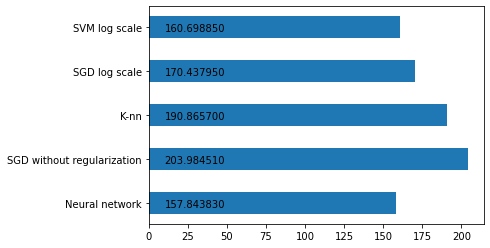

In [10]:
import matplotlib.pyplot as plt

x = [
    u'Neural network', u'SGD without regularization', u'K-nn',
    u'SGD log scale', u'SVM log scale'
]
y = [157.84383, 203.98451, 190.8657, 170.43795, 160.69885]

fig, ax = plt.subplots()
width = 0.5  # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width)
for i, v in enumerate(y):
    ax.text(10, i - width / 5, f"{v:02f}")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
# plt.title('title')
# plt.xlabel('x')
# plt.ylabel('y')
plt.savefig('MAE.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

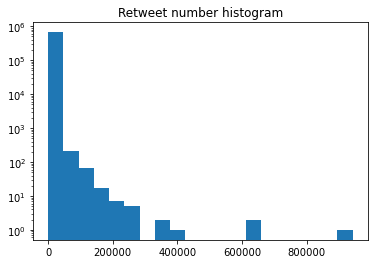

In [21]:
X, Y = load('data_all.p')
fig, ax = plt.subplots()
ax.hist(Y, bins=20)
plt.title('Retweet number histogram')
plt.yscale('log', nonpositive='clip')
plt.savefig('RNH.png', dpi=300, format='png')
plt.show()

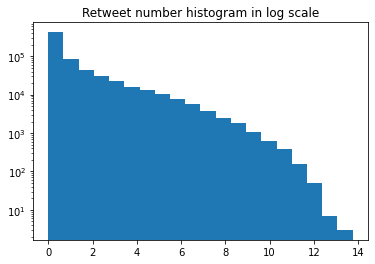

In [24]:
fig, ax = plt.subplots()
ax.hist(np.log(Y + 1), bins=20)
plt.title('Retweet number histogram in log scale')
plt.yscale('log', nonpositive='clip')
plt.savefig('RNHlog.png', dpi=300, format='png')
plt.show()

In [4]:
def split(_X, _Y, _classes=list(range(6))):
    _Y_new = np.array(normalize(_Y))
    _new = []
    _len = []
    _n_s = len(_X)
    _n_f = len(_X[0])
    for k in _classes:
        if k == _classes[-1]:
            _new_k = [
                np.append(_X[i], k) for i in range(_n_s) if _Y_new[i] >= k
            ]
        else:
            _new_k = [
                np.append(_X[i], k) for i in range(_n_s) if _Y_new[i] == k
            ]
        _new.append(_new_k)
        _len.append(len(_new_k))
    _size = np.min(_len)
    print(_size)
    _data = []

    for k in _classes:
        _idx = np.random.randint(_len[k], size=_size)
        _new_k = np.array(_new[k])[_idx, :]
        _data.append(_new_k)

    _data = np.array(_data).reshape((_size * len(_classes), _n_f + 1))
    return _data[:, :-1], _data[:, -1].astype(int)

In [6]:
X, Y = load('data_all.p')
ratio = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio)
X_train_new, Y_train_new = split(X_train, Y_train)
dt_regressor = tree.DecisionTreeRegressor().fit(X_train_new, Y_train_new)

15368


In [7]:
_pred = rebuild(dt_regressor.predict(X_test))
MAE(_pred, Y_test)

159.3953908698569

In [10]:
svm_regressor = svm.LinearSVC(dual=False).fit(X_train_new, Y_train_new)
_pred = rebuild(svm_regressor.predict(X_test))
MAE(_pred, Y_test)

155.1950494157229

In [27]:
def acc(_pred, _true, _classes):
    _test = np.array(normalize(_true))
    for _ in range(len(_test)):
        if _test[_] >= _classes[-1]:
            _test[_] = _classes[-1]

    return accuracy_score(_pred, _test)

In [52]:
X, Y = load('data_all.p')
ratio = 0.7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ratio)

In [78]:
classes = list(range(8))
X_train_new, Y_train_new = split(X_train, Y_train, classes)

sgd_regressor = SGDClassifier().fit(X_train_new, Y_train_new)
svm_regressor = svm.LinearSVC(dual=False).fit(X_train_new, Y_train_new)
dt_regressor = tree.DecisionTreeClassifier(max_depth=5).fit(
    X_train_new, Y_train_new)

_pred_raw_svm = svm_regressor.predict(X_test)
_pred_svm = rebuild(_pred_raw_svm)
print(MAE(_pred_svm, Y_test), acc(_pred_raw_svm, Y_test, classes))

_pred_raw_dt = dt_regressor.predict(X_test)
_pred_dt = rebuild(_pred_raw_dt)
print(MAE(_pred_dt, Y_test), acc(_pred_raw_dt, Y_test, classes))

_pred_raw_sgd = sgd_regressor.predict(X_test)
_pred_sgd = rebuild(_pred_raw_sgd)
print(MAE(_pred_sgd, Y_test), acc(_pred_raw_sgd, Y_test, classes))

3085
202.80681866948186 0.7497897194256337
162.35717013844186 0.7364047171511703
163.19628189613 0.7086240784131971


In [89]:
sgd_regressor = SGDRegressor().fit(X_train, Y_train)
svm_regressor = svm.LinearSVR(dual=False,
                              loss='squared_epsilon_insensitive').fit(
                                  X_train, Y_train)
dt_regressor = tree.DecisionTreeRegressor(max_depth=5).fit(X_train, Y_train)

_pred_raw_svm = svm_regressor.predict(X_test)
print(MAE(_pred_raw_svm, Y_test))

_pred_raw_dt = dt_regressor.predict(X_test)
print(MAE(_pred_raw_dt, Y_test))

_pred_raw_sgd = sgd_regressor.predict(X_test)
print(MAE(_pred_raw_sgd, Y_test))

273.12452426905605
231.88195839496643
247.80394757388274


In [90]:
k = [2, 3, 4, 5, 6, 7, 8]
MAE = [
    [148.06540584150852, 148.06477929122573, 148.06518268661327],
    [147.78927311584314, 147.71758889718566, 147.8738230724996],
    [147.51969985666588, 147.41857206615686, 147.59172524482668],
    [148.03661027714122, 147.47420629811776, 148.08812687214083],
    [151.66737046287474, 149.1159482795616, 149.96307430199724],
    [166.60576898318612, 154.81499815468067, 154.34414990859233],
    [202.96594098411308, 162.35717013844186, 163.19628189613],
    [273.12452426905605, 231.88195839496643, 247.80394757388274],
]

ACC = [
    [0.9750002145720147, 0.9754014642394281, 0.975109646299491],
    [0.8472590570847388, 0.8691475483001605, 0.8310009355339839],
    [0.8087927320167194, 0.8149209087553965, 0.8120198951171992],
    [0.7853378650942829, 0.7901142381406048, 0.7588575327651467],
    [0.7711889864476316, 0.7574349203079538, 0.7352031138690768],
    [0.7609260069864648, 0.7491095261391628, 0.6984812592802396],
    [0.7548021216880809, 0.7364047171511703, 0.7051244088540997],
]

In [91]:
MAE = np.array(MAE)
ACC = np.array(ACC)

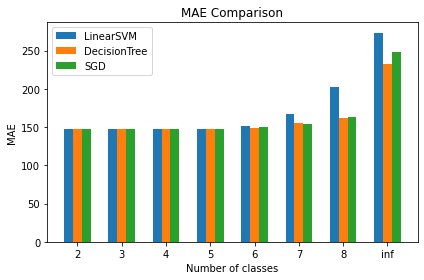

In [106]:
fig, ax = plt.subplots()
x = np.arange(len(k) + 1)
labels = k + [np.inf]
width = 0.2
rects1 = ax.bar(x - width, MAE[:, 0], width, label='LinearSVM')
rects2 = ax.bar(x, MAE[:, 1], width, label='DecisionTree')
rects3 = ax.bar(x + width, MAE[:, 2], width, label='SGD')
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Number of classes')
ax.legend()
fig.tight_layout()
plt.savefig('MAE-classes.png', dpi=300, format='png')

plt.show()

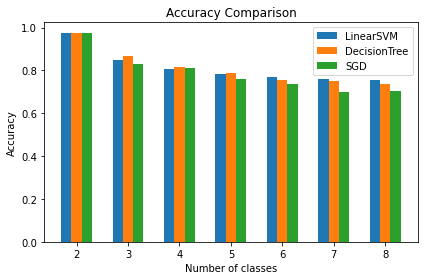

In [107]:
fig, ax = plt.subplots()
x = np.arange(len(k))
labels = k
width = 0.2
rects1 = ax.bar(x - width, ACC[:, 0], width, label='LinearSVM')
rects2 = ax.bar(x, ACC[:, 1], width, label='DecisionTree')
rects3 = ax.bar(x + width, ACC[:, 2], width, label='SGD')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Number of classes')
ax.legend()
fig.tight_layout()
plt.savefig('ACC-classes.png', dpi=300, format='png')

plt.show()